# Axis & Backbone

This notebook demonstrates the process of 3D models reconstruction based on 3D spatial transcriptome data. This is done in the following five steps:

1. Construct the original 3D point cloud model (Embryo);
2. Construct the mesh model based on the 3D point cloud model (Embryo);
3. Construct the cell model based on the 3D point cloud model (Embryo);
4. Construct the voxel model based on the mesh model (Embryo);
5. Construct the subtype models based on the embryo model (CNS);

This example reconstructs 3D Drosophila Embryo/CNS models based on 3D spatial transcriptomics data of Drosophila Embryo.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gseapy as gp
from sklearn.decomposition import PCA

import dynamo as dyn
import spateo as st

2023-07-26 16:33:30.556553: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 16:33:30.578687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 16:33:30.922407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the data

In [2]:
cpo = [(553, 1098, 277), (1.967, -6.90, -2.21), (0, 0, 1)]

# adata = st.sample_data.drosophila(filename="E7-9h_cellbin.h5ad")
adata = st.read_h5ad("E7-9h_cellbin.h5ad")
adata.uns["pp"] = {}
adata.uns["__type"] = "UMI"

cns_adata = st.read_h5ad("E7-9h_cellbin_CNS.h5ad")
cns_adata.uns["pp"] = {}
cns_adata.uns["__type"] = "UMI"

adata, cns_adata

(AnnData object with n_obs × n_vars = 25921 × 8136
     obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
     uns: 'pp', '__type'
     obsm: '3d_align_spatial'
     layers: 'counts_X', 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 4756 × 8136
     obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
     uns: '__type', 'pp'
     obsm: '3d_align_spatial'
     layers: 'counts_X', 'spliced', 'unspliced')

## Reconstruct the models (point cloud and mesh) corresponding to the drosophila embryo

See also [3D Reconstruction](./3D%20Reconstruction.ipynb) for more details on 3D reconstructed models.

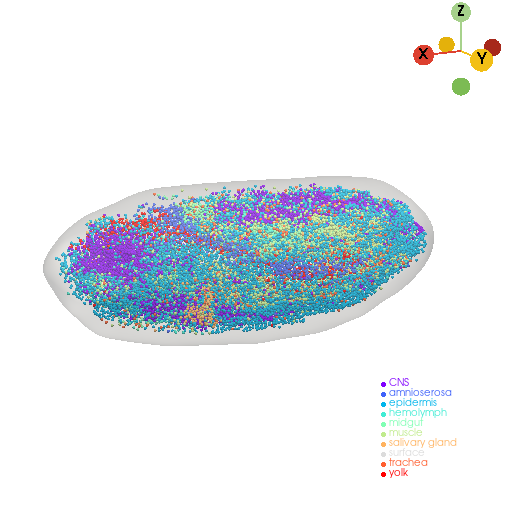

In [3]:
# Reconstruct point cloud model
pc, _ = st.tdr.construct_pc(adata=adata.copy(), spatial_key="3d_align_spatial", groupby="anno_tissue")
st.tdr.add_model_labels(model=pc, labels=["Point Cloud"]*pc.n_points, key_added="axis", where="point_data",inplace=True, alphamap=0.4, colormap="gainsboro")

# Reconstruct mesh model
mesh, _, _ = st.tdr.construct_surface(pc=pc, alpha=0.3, cs_method="marching_cube", cs_args={"mc_scale_factor": 1.8}, smooth=8000, scale_factor=1.0)
st.tdr.add_model_labels(model=mesh, labels=["Mesh"]*mesh.n_cells, key_added="axis", where="cell_data",inplace=True, alphamap=0.3, colormap="gainsboro")

# Visualization
st.pl.three_d_plot(model=st.tdr.collect_models([pc, mesh]), key="groups", model_style=["points", "surface"], jupyter="static", cpo=cpo)

## Calculate the AP and DV Axis of the drosophila embryo

In [4]:
pca = PCA(n_components=3)
pca_spatial = pca.fit_transform(np.asarray(adata.obsm["3d_align_spatial"])).astype(int)
adata.obs["ap_axis"] = pca_spatial[:, [0]]
adata.obs["dv_axis"] = pca_spatial[:, [2]]

In [5]:
empty_array = np.zeros(shape=[adata.shape[0], 1])
ap_line, _ = st.tdr.construct_axis_line(
    axis_points= np.c_[adata.obs["ap_axis"].values, empty_array, empty_array],
    key_added="axis",
    label="AP Axis",
    color="orangered",
)

dv_line, _ = st.tdr.construct_axis_line(
    axis_points= np.c_[empty_array, empty_array, adata.obs["dv_axis"].values],
    key_added="axis",
    label="DV Axis",
    color="skyblue",
)

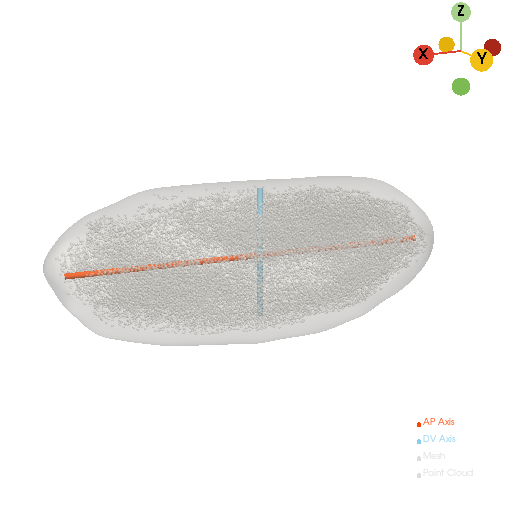

In [6]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([pc, mesh, ap_line, dv_line]), key="axis",
    model_style=["points", "surface", "wireframe", "wireframe"],
    model_size=[3, None, 6, 6], cpo=cpo, jupyter="static",
)

## Reconstruct the models (point cloud, mesh and voxel) corresponding to the drosophila CNS

See also [3D Reconstruction](./3D%20Reconstruction.ipynb) for more details on 3D reconstructed models.

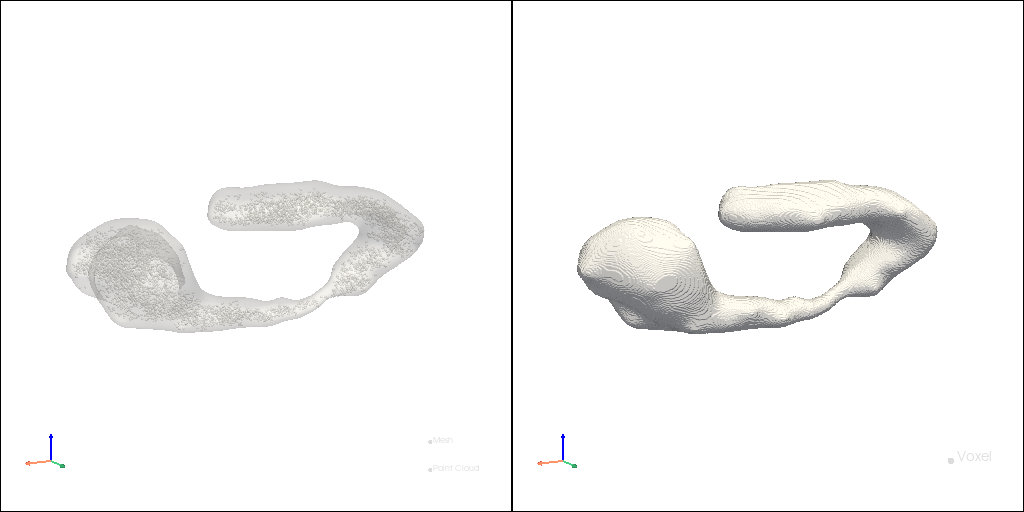

In [15]:
# Reconstruct point cloud model
cns_pc, _ = st.tdr.construct_pc(adata=cns_adata.copy(), spatial_key="3d_align_spatial", groupby="anno_tissue")
st.tdr.add_model_labels(model=cns_pc, labels=["Point Cloud"]*cns_pc.n_points, key_added="backbone", where="point_data",inplace=True, alphamap=0.4, colormap="gainsboro")

# Reconstruct mesh model
cns_mesh, _, _ = st.tdr.construct_surface(pc=cns_pc, alpha=0.3, cs_method="marching_cube", cs_args={"mc_scale_factor": 0.95}, smooth=4000, scale_factor=1.0)
st.tdr.add_model_labels(model=cns_mesh, labels=["Mesh"]*cns_mesh.n_cells, key_added="backbone", where="cell_data",inplace=True, alphamap=0.3, colormap="gainsboro")

# Reconstruct voxel model
cns_voxel, _ = st.tdr.voxelize_mesh(mesh=cns_mesh, voxel_pc=None, key_added="backbone", label="Voxel", color="gainsboro", smooth=500)

# Visualization
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models([st.tdr.collect_models([cns_pc, cns_mesh]), cns_voxel]), key="backbone",
    model_style=[["points", "surface"], "surface"], jupyter="static", cpo=[cpo], shape=(1, 2), ambient=[0.2, 0.1]
)

In [16]:
cns_voxel

UnstructuredGrid (0x7f239bf474c0)
  N Cells:    2565288
  N Points:   2684508
  X Bounds:   -2.530e+02, 2.556e+02
  Y Bounds:   -1.135e+02, 5.754e+01
  Z Bounds:   -8.800e+01, 9.099e+01
  N Arrays:   4

In [25]:
np.random.seed(19491001)
import pyvista as pv
sampling = np.asarray(cns_voxel.points)[np.random.choice(np.asarray(cns_voxel.points).shape[0], size=2000, replace=False)]
downsampling_voxel = pv.PolyData(sampling)

In [26]:
downsampling_voxel.plot()

Widget(value="<iframe src='http://localhost:38865/index.html?ui=P_0x7f23d5d4a1c0_15&reconnect=auto' style='wid…

## Calculate the Backbone of drosophila CNS

In [27]:
_, backbone, backbone_length, _ = st.tdr.changes_along_branch(
    model=downsampling_voxel,
    rd_method="PrinCurve",
    NumNodes=30,
    epochs=500,
    scale_factor=10,
    inplace=True,
    color="orangered",
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([cns_pc, cns_mesh, backbone]),
    key=["backbone", "backbone", "tree"],
    opacity=1,
    model_style=["points",  "surface", "wireframe"],
    model_size=[3, None, 5],
    show_legend=True,
    jupyter="trame",
    cpo=cpo,
)

63/63 [==============================] - 0s 202us/step
|-----> [Running TRN] in progress: 100.0000%|-----> [Running TRN] completed [0.1525s]


Widget(value="<iframe src='http://localhost:38865/index.html?ui=P_0x7f239834f550_16&reconnect=auto' style='wid…